## 🌟 Time-Series Anomaly Detection using Transformer and XGBoost
### Benchmarked performance against traditional Isolation Forest and GcForest


##### 1. Transformer captured long-term temporal patterns and XGBoost leveraged structured features for nonlinear prediction.

##### 2. Used the output of Transformer as enriched features for XGBoost to improve prediction accuracy and robustness across noisy financial time series.

In [610]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import xgboost as xgb
import math

#### Step 1: Randomly generate 1000 time-series sample with seasonality, trend and noise

In [615]:
def generate_data(n_samples = 1000, rolling_window=30):
    np.random.seed(42)
    time = np.arange(n_samples)
    seasonal = 10 * np.sin(time*2*np.pi/50)
    trend = 0.05*time
    noise = np.random.normal(scale=2, size=n_samples)
    signal = seasonal + trend + noise
    df = pd.DataFrame({"timestamp":time, "value":signal})
    df['mean'] = pd.DataFrame(df['value']).rolling(window=rolling_window, min_periods=1).mean().values
    df['sin_time'] = np.sin(2 * np.pi * df['timestamp'] / 1000)
    df['cos_time'] = np.cos(2 * np.pi * df['timestamp'] / 1000)
    return df

In [616]:
def plot_original_series(df):
    plt.figure(figsize=(14,6))
    plt.plot(df['timestamp'], df['value'], color='crimson')
    plt.title("Original time series")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    plt.show()

In [617]:
data = generate_data()
data.head(10)

,timestamp,value,mean,sin_time,cos_time
0,0,0.993428,0.993428,0.000000,1.000000
1,1,1.026804,1.010116,0.006283,0.999980
2,2,3.882276,1.967503,0.012566,0.999921
3,3,6.877305,3.194953,0.018848,0.999822
4,4,4.549230,3.465809,0.025130,0.999684
5,5,5.659579,3.831437,0.031411,0.999507
6,6,10.303897,4.756074,0.037690,0.999289
7,7,9.590002,5.360315,0.043968,0.999033
8,8,7.904330,5.642983,0.050244,0.998737
9,9,10.583391,6.137024,0.056519,0.998402


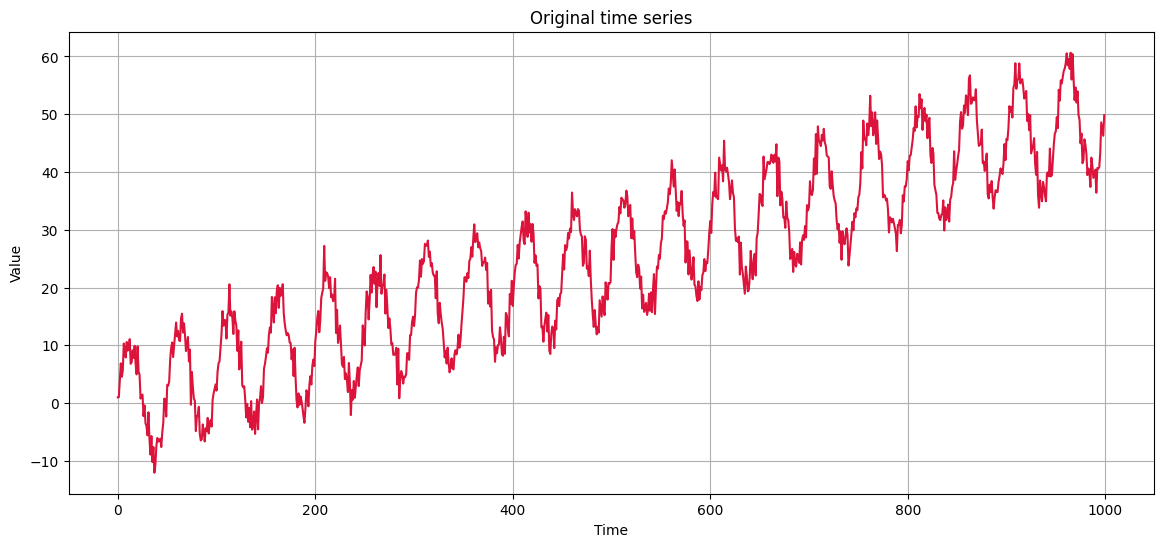

In [618]:
plot_original_series(data)

#### Step2: Prepare Transformer training features and targets

In [619]:
class TimeSeriesDataset(Dataset):
    def __init__(self, df, window_size):
        self.X = []
        self.y = []
        for i in range(df.shape[0]-window_size):
            window_raw = df['value'][i:i+window_size].values.reshape(-1, 1)
            window_roll = df['mean'][i:i+window_size].values.reshape(-1, 1)
            window_sin = df['sin_time'][i:i+window_size].values.reshape(-1, 1)
            window_cos = df['cos_time'][i:i+window_size].values.reshape(-1, 1)
            window_features = np.concatenate([window_raw, window_roll, window_sin, window_cos], axis=1)
            self.X.append(window_features)
            self.y.append(df['value'].values[i+window_size])
        self.X = torch.tensor(self.X, dtype = torch.float32)
        self.y = torch.tensor(self.y, dtype = torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [620]:
dataset_tmp = TimeSeriesDataset(data, 24)
print(dataset_tmp.X.shape, dataset_tmp.y.shape)

torch.Size([976, 24, 4]) torch.Size([976])


In [621]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()

        # 创建位置编码矩阵 [max_len, d_model]
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)  # shape: [max_len, 1]
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))  # shape: [d_model/2]

        pe[:, 0::2] = torch.sin(position * div_term)  # 偶数维
        pe[:, 1::2] = torch.cos(position * div_term)  # 奇数维

        pe = pe.unsqueeze(1)  # shape: [max_len, 1, d_model]
        self.register_buffer('pe', pe)  # 不参与梯度更新

    def forward(self, x):
        """
        Args:
            x: Tensor of shape [seq_len, batch_size, d_model]
        Returns:
            Tensor with positional encoding added
        """
        x = x + self.pe[:x.size(0)]
        return x

#### Step3: Build encoder-only Transformer model: input layer, transformer encoder layer, transformer encoder, output layer 

In [622]:
class TransformerModel(nn.Module):
    def __init__(self, input_size = 4, d_model = 256, nhead = 4, num_layers = 2):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.input_linear = nn.Linear(input_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model,      # 输入特征维度（比如 512）
                                                    nhead=nhead,        # 多头注意力的头数
                                                    dim_feedforward=2048,  # FFN内部隐层维度（默认2048）
                                                    dropout=0.5,            # dropout 概率
                                                    activation="relu",     # 或 "gelu"
                                                    batch_first=False      # 如果 True，输入 shape 变为 [batch, seq, dim]
                                                   )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_layer = nn.Linear(d_model, 1)

    def forward(self, src):
        src = self.input_linear(src)
        
        # src.shape = (batch_size, seq_len, feature_dim) -> encoder (seq_len, batch_size, feature_dim)
        src = src.permute(1,0,2)
        src = self.pos_encoder(src) 
        output = self.transformer_encoder(src)
        
        # select the last output of the time-series
        output = output[-1]
        output = self.output_layer(output)
        
        # remove the dimensions where value = 1
        return output.squeeze(-1)

#### Step4: Train transformer model

In [623]:
def train_transformer_model(data, window_size=24, epochs=20, lr=1e-3):
    dataset = TimeSeriesDataset(data, window_size)
    train_size = int(len(dataset)*0.8)
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, len(dataset)-train_size])
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TransformerModel().to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(),
                                lr=lr,
                                betas=(0.9, 0.999),
                                eps=1e-8,
                                weight_decay=1e-2) # 对参数太大的惩罚
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            
            # 增加特征维度 → [B, T, 1]
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            #清零旧梯度
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()

            #更新模型参数
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch+1}, loss: {epoch_loss / len(train_loader) :.4f}")

    return model, test_loader

In [624]:
model, test_loader = train_transformer_model(data)

/opt/anaconda3/envs/python3.9/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1, loss: 523.4695
Epoch 2, loss: 333.4894
Epoch 3, loss: 207.4002
Epoch 4, loss: 128.4256
Epoch 5, loss: 93.4930
Epoch 6, loss: 72.5526
Epoch 7, loss: 55.8395
Epoch 8, loss: 81.8413
Epoch 9, loss: 53.7431
Epoch 10, loss: 45.4379
Epoch 11, loss: 48.7407
Epoch 12, loss: 47.6071
Epoch 13, loss: 30.4191
Epoch 14, loss: 26.8119
Epoch 15, loss: 26.2633
Epoch 16, loss: 23.1895
Epoch 17, loss: 30.7276
Epoch 18, loss: 19.0672
Epoch 19, loss: 17.6836
Epoch 20, loss: 16.1134


#### Step5: Extract transformer outputs of each epochs

In [625]:
def extract_transformer_features(model, data, window_size=24):
    model.eval()
    features = []
    targets = []

    # 关闭梯度计算，加速 & 降低内存
    with torch.no_grad():
        for i in range(window_size, len(data)):
            
            # shape: [1, window_size, 1]
            x_seq = torch.tensor(data[i-window_size:i].values, dtype=torch.float32).unsqueeze(0)
            output = model.input_linear(x_seq)
            output = output.permute(1, 0, 2)
            encoded = model.transformer_encoder(output)
            features.append(encoded[-1].squeeze().numpy())
            targets.append(data[['value']].iloc[i])
    return np.array(features), np.array(targets)

In [626]:
X, y = extract_transformer_features(model, data[['value','mean','sin_time','cos_time']])
print(X.shape, y.shape)

(976, 256) (976, 1)


In [627]:
# add_rolling_mean(data['value'])

In [628]:
def enhance_time_series_features(X, period=24, roll_window=5):
    # 周期特征
    n = X.shape[0]
    t = np.arange(n)
    sin_feat = np.sin(2 * np.pi * t / period).reshape(-1, 1)
    cos_feat = np.cos(2 * np.pi * t / period).reshape(-1, 1)
    X_with_period = np.concatenate([X, sin_feat, cos_feat], axis=1)

    return X_with_period

In [629]:
X = enhance_time_series_features(X)

In [630]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = False)
xgb_model = xgb.XGBRegressor(n_estimators = 25, max_depth=3, learning_rate = 0.5, reg_lambda = 4, \
                             reg_alpha = 0.3, colsample_bytree = 0.6, subsample = 0.6,early_stopping_rounds=5)
xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)

[0]	validation_0-rmse:17.00957
[1]	validation_0-rmse:11.86283
[2]	validation_0-rmse:9.90609
[3]	validation_0-rmse:7.86344
[4]	validation_0-rmse:6.77989
[5]	validation_0-rmse:6.30410
[6]	validation_0-rmse:6.23244
[7]	validation_0-rmse:6.23707
[8]	validation_0-rmse:6.12692
[9]	validation_0-rmse:6.09218
[10]	validation_0-rmse:6.08714
[11]	validation_0-rmse:6.16226
[12]	validation_0-rmse:6.22633
[13]	validation_0-rmse:5.81154
[14]	validation_0-rmse:5.81025
[15]	validation_0-rmse:5.87744
[16]	validation_0-rmse:5.84574
[17]	validation_0-rmse:5.72272
[18]	validation_0-rmse:5.82976
[19]	validation_0-rmse:5.78223
[20]	validation_0-rmse:5.77120
[21]	validation_0-rmse:5.75975
[22]	validation_0-rmse:5.86029


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=5,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.5, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=25, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [631]:
def evaluate_predictions(y_true, y_pred):
    print("MSE:", mean_squared_error(y_true, y_pred))
    print("MAE:", mean_absolute_error(y_true, y_pred))
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label="Actual", color="dodgerblue")
    plt.plot(y_pred, label="Predicted", color="orange")
    plt.title("Actual VS Predicted Values (XGBoost on Transformer features)")
    plt.legend()
    plt.grid(True)
    plt.show()

Performance on training dataset
MSE: 4.451559997862277
MAE: 1.653021657717595


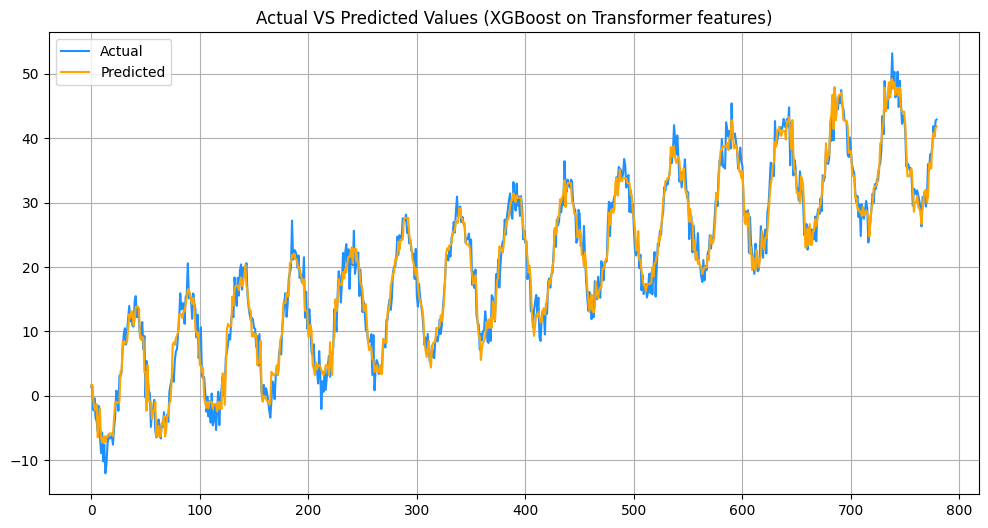

Performance on testing dataset
MSE: 32.74952255587137
MAE: 4.603828183096619


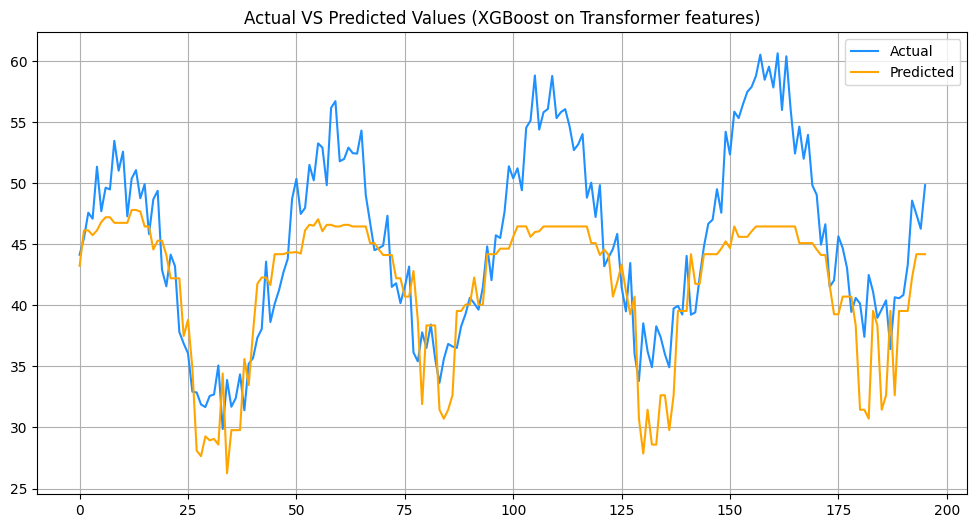

In [632]:
print("Performance on training dataset")
evaluate_predictions(y_train, xgb_model.predict(X_train))
print("Performance on testing dataset")
evaluate_predictions(y_test, xgb_model.predict(X_test))

In [597]:
print(y_test.shape, xgb_model.predict(X_test).reshape(-1,1).shape)

(196, 1) (196, 1)


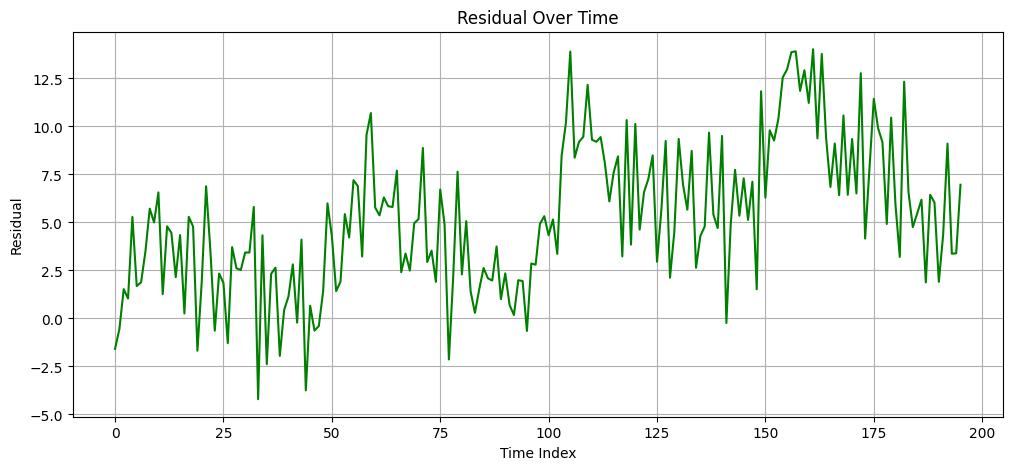

In [598]:
plt.figure(figsize=(12,5))
plt.plot(np.arange(len(y_test)), y_test-xgb_model.predict(X_test).reshape(-1,1), color="green")
plt.title("Residual Over Time")
plt.xlabel("Time Index")
plt.ylabel("Residual")
plt.grid(True)

plt.show()

#### 🔧 Model Optimization Recommendations
##### 1. Transformer Architecture Tuning:

Hyperparameters such as d_model (embedding dimension), nhead (number of attention heads), and num_layers (number of encoder layers) can be optimized via cross-validation.

##### 2. XGBoost Hyperparameter Optimization:

Use tools like GridSearchCV, RandomizedSearchCV, or Optuna to fine-tune max_depth, learning_rate, subsample, and colsample_bytree.

Select evaluation metrics like RMSE or MAE on the validation set for optimization objectives.

##### 3. Enhanced Feature Engineering:

In addition to features extracted from the Transformer, enrich the input with:

- Seasonal features (e.g., hour of day, day of week)

- Lagged values (e.g., past t-step observations)

- Rolling statistics (e.g., moving average, variance, min/max)

- Calendar-based features (e.g., holidays, weekends)

- Leveraging domain knowledge to create meaningful derived features can significantly improve performance.

##### 4. Improving Sequence Representations:

Instead of using only the final time step of the Transformer encoder, consider averaging the last K time steps or applying attention-based pooling for more robust sequence representations.

##### 5. Preventing Overfitting:

Apply early stopping to terminate training when validation loss no longer improves.

Use checkpointing to save the best-performing model weights during training.

Recommended Hyperparameter Tuning Workflow:

Employ time series–aware cross-validation (e.g., TimeSeriesSplit) to avoid data leakage.

##### 6. Suggested tuning sequence:

Fix Transformer parameters and tune XGBoost hyperparameters.

Fix XGBoost configuration and fine-tune the Transformer architecture (including window size).

Jointly fine-tune both components for final performance.

Monitor training vs. validation loss gaps; adjust learning rate, batch size, or model complexity accordingly.

##### 7. Advanced Extensions:

Extend to multivariate time series by incorporating related variables (e.g., external indicators, macro factors).

Incorporate domain-specific auxiliary features or external knowledge sources.

Use SHAP values to interpret XGBoost predictions and guide feature refinement.

